In [ ]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

train_images = train_images/255.
test_images = test_images/255.

valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

11501568/11490434 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

class ConvBNRelu(Model):
    def __init__(self, filters, kernel_size=3, strides=(1, 1), padding='same'):
        super(ConvBNRelu, self).__init__()
        self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                           padding=padding, kernel_initializer='glorot_normal')
        
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer


In [ ]:
class DenseBNRelu(Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer

In [ ]:
class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=(3, 3), padding='valid')
        self.pool1 = MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.pool2 = MaxPool2D()
        self.conv3 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.flat = Flatten()
        self.dense4 = DenseBNRelu(units=64)
        self.drop = Dropout(0.2)
        self.outputs = Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.flat(net)
        net = self.dense4(net)
        net = self.drop(net)
        net = self.outputs(net)

        return net


In [ ]:
del model

In [ ]:
model = MNISTModel()
model(Input(shape=(28, 28, 1)))
model.summary()

Model: "mnist_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu_6 (ConvBNRelu)  multiple                 448       
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_7 (ConvBNRelu)  multiple                 18752     
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_8 (ConvBNRelu)  multiple                 37184     
                                                                 
 flatten_2 (Flatten)         multiple                

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy', 
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [ ]:
!rm '/content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/'*

In [ ]:
learning_rate = 0.001
batch_size = 200

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5,  staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size, 
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
298/300 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9497
Epoch 1: val_accuracy improved from -inf to 0.28941, saving model to /content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/mnist-1-2.33889-0.28941.hdf5
300/300 [==============================] - 7s 22ms/step - loss: 0.2085 - accuracy: 0.9499 - val_loss: 2.3389 - val_accuracy: 0.2894
Epoch 2/100
299/300 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9868
Epoch 2: val_accuracy improved from 0.28941 to 0.98094, saving model to /content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/mnist-2-0.06585-0.98094.hdf5
300/300 [==============================] - 6s 19ms/step - loss: 0.0499 - accuracy: 0.9868 - val_loss: 0.0659 - val_accuracy: 0.9809
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9903
Epoch 3: val_accuracy improved from 0.98094 to 0.98812, saving model to /content/drive/MyDri

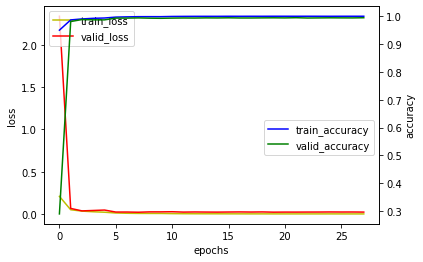

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()

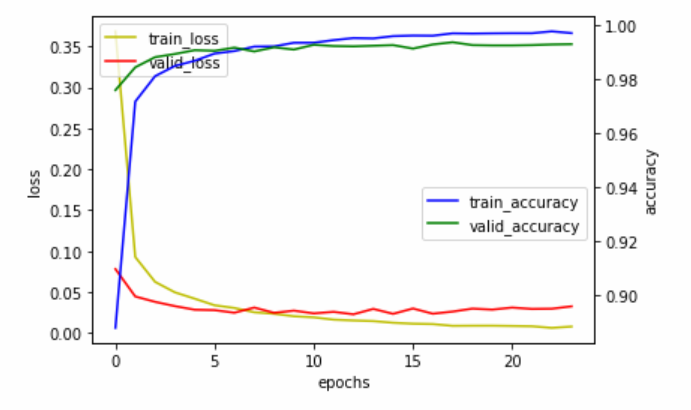

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [ ]:
# 3 채널로 만들기 위한 작업
train_images = train_images.reshape(-1, 784).astype('float32')
test_images = test_images.reshape(-1, 784).astype('float32')

print(train_images.shape, test_images.shape)

(60000, 784) (10000, 784)


In [ ]:
# 3 채널로 만들기
train_images = np.dstack([train_images]*3)
test_images = np.dstack([test_images]*3)

In [ ]:
train_images.shape, test_images.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
#이미지 형식으로 변경
train_images = train_images.reshape(-1, 28, 28, 3)
test_images = test_images.reshape(-1, 28, 28, 3)


In [ ]:
train_images.shape,  test_images.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
train_images[0][0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

#48*48 사이즈로 변경

train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_images])

In [ ]:
train_images.shape,  test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
train_images = train_images/ 255.
test_images = test_images / 255.


In [ ]:
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
layer_dict = {layer.name : layer for layer in vgg_model.layers}
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f2c7cd301d0>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f2c7cabe410>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f2c7c78ccd0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f2c7cc8c910>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f2c7cc8ef10>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f2c7cd30850>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f2c7cc94650>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f2c7cc8ca10>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f2c7cc9ebd0>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f2c7cca5d10>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f2c7c78c7d0>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f2c7ccaa390>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f2c7cc32590>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f2c7ccaa75

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

x = layer_dict['block2_conv2'].output

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)


In [ ]:
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 conv2d (Conv2D)             (None, 22, 22, 64)        73792 

In [ ]:
for layer in custom_model.layers[:7]:
    layer.trainable = False

custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-vgg-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy', 
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [ ]:
hist = custom_model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                        epochs=100, batch_size=200,
                        callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 2.6991 - accuracy: 0.8024
Epoch 1: val_accuracy improved from -inf to 0.96965, saving model to /content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/mnist-vgg-1-0.11053-0.96965.hdf5
300/300 [==============================] - 29s 69ms/step - loss: 2.6991 - accuracy: 0.8024 - val_loss: 0.1105 - val_accuracy: 0.9696
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9281
Epoch 2: val_accuracy improved from 0.96965 to 0.97647, saving model to /content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/mnist-vgg-2-0.08159-0.97647.hdf5
300/300 [==============================] - 20s 65ms/step - loss: 0.2294 - accuracy: 0.9281 - val_loss: 0.0816 - val_accuracy: 0.9765
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9356
Epoch 3: val_accuracy improved from 0.97647 to 0.97882, saving model to /content/d

In [ ]:
!ls -la '/content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/'

total 194195
-rw------- 1 root root  419664 Mar  4 05:01 mnist-1-2.33889-0.28941.hdf5
-rw------- 1 root root  419664 Mar  4 05:03 mnist-14-0.02255-0.99412.hdf5
-rw------- 1 root root  419664 Mar  4 05:03 mnist-16-0.02305-0.99435.hdf5
-rw------- 1 root root  419664 Mar  4 05:01 mnist-2-0.06585-0.98094.hdf5
-rw------- 1 root root  419664 Mar  4 05:03 mnist-22-0.02206-0.99471.hdf5
-rw------- 1 root root  419664 Mar  4 05:02 mnist-3-0.03653-0.98812.hdf5
-rw------- 1 root root  419664 Mar  4 05:02 mnist-6-0.02274-0.99329.hdf5
-rw------- 1 root root  419664 Mar  4 05:02 mnist-8-0.02056-0.99400.hdf5
-rw------- 1 root root 9309104 Mar  4 06:50 mnist-vgg-10-0.06268-0.98329.hdf5
-rw------- 1 root root 9309104 Mar  4 06:47 mnist-vgg-1-0.11053-0.96965.hdf5
-rw------- 1 root root 9309328 Mar  4 06:38 mnist-vgg-10-1.77626-0.39682.hdf5
-rw------- 1 root root 9309328 Mar  4 06:35 mnist-vgg-1-1.98993-0.31235.hdf5
-rw------- 1 root root 9309104 Mar  4 06:51 mnist-vgg-12-0.05274-0.98376.hdf5
-rw------- 1

In [ ]:
saved_path = "/content/drive/MyDrive/2021 K 디지털 - 멀티/공유폴더/실습 폴더/models/mnist-vgg-33-0.05430-0.98824.hdf5"
custom_model.load_weights(saved_path)

custom_model.evaluate(test_images, test_labels)

47/47 [==============================] - 1s 18ms/step - loss: 0.0551 - accuracy: 0.9867


[0.05509611591696739, 0.9866666793823242]